In [66]:
import pickle
import io
import torch
from torch import linalg as LA
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from models import IrisClassifier
from sklearn.metrics import accuracy_score
NUM_OF_MODELS = 500

device = "cuda" if torch.cuda.is_available() else "cpu"

In [103]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.33
)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train, device=device, dtype=torch.float32),
    torch.tensor(X_test, device=device, dtype=torch.float32),
    torch.tensor(y_train, device=device, dtype=torch.long),
    torch.tensor(y_test, device=device, dtype=torch.long),
)
class_counts = torch.bincount(y_test)
total_samples = y_test.size(0)
class_weights = class_counts.float() / total_samples
print("Class counts in the test set:", class_counts)
print("Class distribution:", class_weights)

Class counts in the test set: tensor([19, 15, 16])
Class distribution: tensor([0.3800, 0.3000, 0.3200])


In [68]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "torch.storage" and name == "_load_from_bytes":
            return lambda b: torch.load(io.BytesIO(b), map_location="cpu")
        else:
            return super().find_class(module, name)


with open('real_matrix_list.pickle', 'rb') as f:
    real_matrices = CPU_Unpickler(f).load()
with open('scrambled_matrix_list.pickle', 'rb') as f:
    scrambled_matrices = CPU_Unpickler(f).load()
with open('generated_matrix_list.pickle', 'rb') as f:
    generated_matrices = CPU_Unpickler(f).load()

In [69]:
real_state_dicts = []
for matrix in real_matrices:
    W = matrix[:, :-1] 
    b = matrix[:, -1] 
    state_dict = {"linear.weight": W, "linear.bias": b}
    real_state_dicts.append(state_dict)
scrambled_state_dicts = []
for matrix in scrambled_matrices:
    W = matrix[:, :-1] 
    b = matrix[:, -1]  
    state_dict = {"linear.weight": W, "linear.bias": b}
    scrambled_state_dicts.append(state_dict)
generated_state_dicts = []
for matrix in generated_matrices:
    W = matrix[:, :-1]  
    b = matrix[:, -1] 
    state_dict = {"linear.weight": W, "linear.bias": b}
    generated_state_dicts.append(state_dict)

In [70]:
real_plot = real_matrices[0:-1:20]
scrambled_plot = scrambled_matrices[0:-1:20]
generated_plot = generated_matrices[0:-1:20]
num_of_objects = len(real_plot)

In [71]:
def metric(A, B):
    return LA.matrix_norm((A - B), ord=2).item()

distances_real_real = []
distances_scrambled_scrambled = []
distances_generated_generated = []
for i in range(num_of_objects):
    for j in range(i + 1, num_of_objects):
        d_r_r = metric(real_plot[i], real_plot[j])
        d_s_s = metric(scrambled_plot[i], scrambled_plot[j])
        d_g_g = metric(generated_plot[i], generated_plot[j])
        distances_real_real.append(d_r_r)
        distances_scrambled_scrambled.append(d_s_s)
        distances_generated_generated.append(d_g_g)

distances_real_scrambled = []
distances_real_generated = []
distances_scrambled_generated = []
for r in real_plot:
    for s in scrambled_plot:
        d_r_s = metric(r, s)
        distances_real_scrambled.append(d_r_s)

for r in real_plot:
    for g in generated_plot:
        d_r_g = metric(r,g)
        distances_real_generated.append(d_r_g)

for s in scrambled_plot:
        for g in generated_plot:
            d_s_g = metric(s, g)
            distances_scrambled_generated.append(d_s_g)


In [72]:
def reshape_to_matrix(distances_list):
    matrix = np.zeros((num_of_objects, num_of_objects))
    index = 0
    for i in range(num_of_objects):
        for j in range(i + 1, num_of_objects):
            matrix[i][j] = distances_list[index]
            matrix[j][i] = distances_list[index]
            index += 1
    return matrix
real_real_matrix = reshape_to_matrix(distances_real_real)
scrambled_scrambled_matrix = reshape_to_matrix(distances_scrambled_scrambled)
generated_generated_matrix = reshape_to_matrix(distances_generated_generated)
real_scrambled_matrix = np.reshape(
    distances_real_scrambled, (num_of_objects, num_of_objects)
)
real_generated_matrix = np.reshape(
    distances_real_generated, (num_of_objects, num_of_objects)
)
scrambled_generated_matrix = np.reshape(
    distances_scrambled_generated, (num_of_objects, num_of_objects)
)

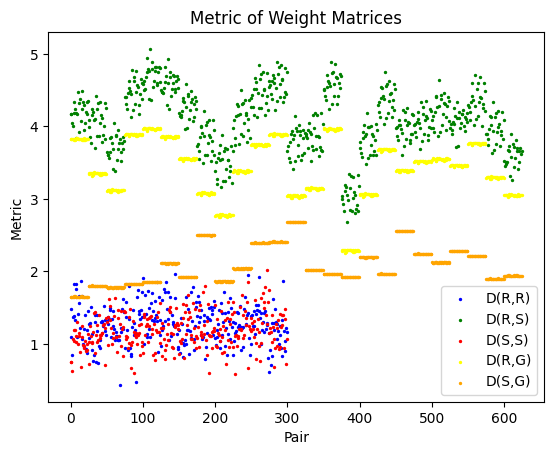

In [73]:
plt.scatter(
    range(len(distances_real_real)),
    distances_real_real,
    color="blue",
    label="D(R,R)",
    s=2,
)
plt.scatter(
    range(len(distances_real_scrambled)),
    distances_real_scrambled,
    color="green",
    label="D(R,S)",
    s=2,
)
plt.scatter(
    range(len(distances_scrambled_scrambled)),
    distances_scrambled_scrambled,
    color="red",
    label="D(S,S)",
    s=2,
)
plt.scatter(
    range(len(distances_real_generated)),
    distances_real_generated,
    color="yellow",
    label="D(R,G)",
    s=2,
)
plt.scatter(
    range(len(distances_scrambled_generated)),
    distances_scrambled_generated,
    color="orange",
    label="D(S,G)",
    s=2,
)
plt.xlabel("Pair")
plt.ylabel("Metric")
plt.legend()
plt.title("Metric of Weight Matrices")
plt.show()

In [127]:
upper_left_block = real_real_matrix
upper_middle_block = real_scrambled_matrix
middle_left_block = real_scrambled_matrix.T
middle_middle_block = scrambled_scrambled_matrix
upper_right_block = real_generated_matrix
middle_right_block = scrambled_generated_matrix
lower_right_block = generated_generated_matrix
lower_middle_block = scrambled_generated_matrix.T
lower_left_block = real_generated_matrix.T


distances_matrix = np.block(
    [
        [upper_left_block, upper_middle_block, upper_right_block],
        [middle_left_block, middle_middle_block, middle_right_block],
        [lower_left_block, lower_middle_block, lower_right_block],
    ]
)

perplexity = min(17, 2 * num_of_objects - 1)
tsne = TSNE(n_components=2, perplexity=perplexity)
embedded_distances_matrix = tsne.fit_transform(distances_matrix)
embedded_real = embedded_distances_matrix[:num_of_objects]
embedded_scrambled = embedded_distances_matrix[num_of_objects : 2 * num_of_objects]
embedded_generated = embedded_distances_matrix[2 * num_of_objects :]

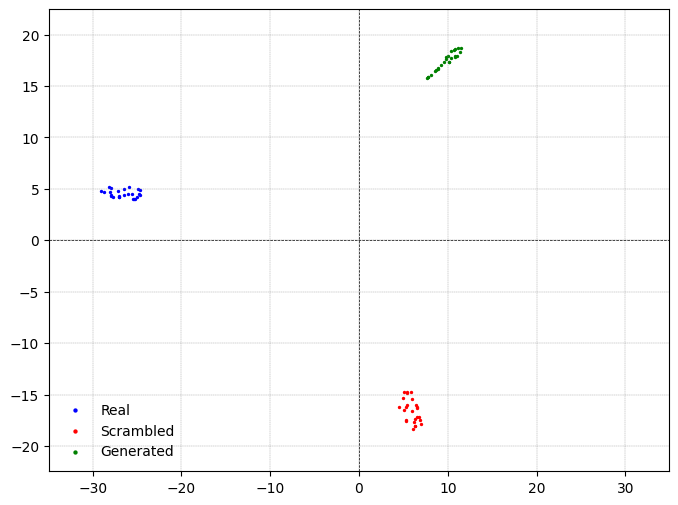

In [165]:
plt.figure(figsize=(8, 6))
plt.scatter(embedded_real[:, 0], embedded_real[:, 1], color="blue", label="Real", s=2)
plt.scatter(
    embedded_scrambled[:, 0],
    embedded_scrambled[:, 1],
    color="red",
    label="Scrambled",
    s=2,
)
plt.scatter(
    embedded_generated[:, 0],
    embedded_generated[:, 1],
    color="green",
    label="Generated",
    s=2,
)
plt.legend(loc="lower left", framealpha=0, markerscale=1.5)
# plt.axis("off")
embedded_data = [embedded_real, embedded_scrambled, embedded_generated]
x_min = np.min([data[:, 0].min() for data in embedded_data])
x_max = np.max([data[:, 0].max() for data in embedded_data])
y_min = np.min([data[:, 1].min() for data in embedded_data])
y_max = np.max([data[:, 1].max() for data in embedded_data])
x_range = max(abs(x_min), abs(x_max))
y_range = max(abs(y_min), abs(y_max))
x_range *= 1.2
y_range *= 1.2
plt.xlim(-x_range, x_range)
plt.ylim(-y_range, y_range)
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="black", linestyle="--", linewidth=0.5)
plt.grid(True, color="gray", linestyle="--", linewidth=0.25)
plt.savefig("t-SNE embedding.png", transparent=True, dpi=300)
plt.show()

In [110]:
def evaluate_models(state_dicts, X_test, y_test):
    accuracies = []
    for state_dict in state_dicts:
        model = IrisClassifier().to(device)
        model.load_state_dict(state_dict)
        model.eval()
        with torch.inference_mode():
            y_pred = model(X_test)
            _, predicted_labels = torch.max(y_pred, 1)
            accuracy = accuracy_score(
                y_test.cpu().numpy(), predicted_labels.cpu().numpy()
            )
            accuracies.append(accuracy)
    return np.array(accuracies)

accuracy_real = evaluate_models(real_state_dicts, X_test, y_test)
accuracy_scrambled = evaluate_models(scrambled_state_dicts, X_test, y_test)
accuracy_generated = evaluate_models(generated_state_dicts, X_test, y_test)

accuracy_real *= 100
accuracy_scrambled *= 100
accuracy_generated *= 100

print(
    "Acc(R): {:0>5.2f} ± {:0>5.2f}".format(
        np.mean(accuracy_real), np.std(accuracy_real)
    )
)
print(
    "Acc(S): {:0>5.2f} ± {:0>5.2f}".format(
        np.mean(accuracy_scrambled), np.std(accuracy_scrambled)
    )
)
print(
    "Acc(G): {:0>5.2f} ± {:0>5.2f}".format(
        np.mean(accuracy_generated), np.std(accuracy_generated)
    )
)

Acc(R): 97.68 ± 01.10
Acc(S): 34.26 ± 19.10
Acc(G): 97.97 ± 00.23
